# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
  """
  Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
  it for the linear classifier. These are the same steps as we used for the
  SVM, but condensed to a single function.  
  """
  # Load the raw CIFAR-10 data
  cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]
  mask = np.random.choice(num_training, num_dev, replace=False)
  X_dev = X_train[mask]
  y_dev = y_train[mask]
  
  # Preprocessing: reshape the image data into rows
  X_train = np.reshape(X_train, (X_train.shape[0], -1))
  X_val = np.reshape(X_val, (X_val.shape[0], -1))
  X_test = np.reshape(X_test, (X_test.shape[0], -1))
  X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
  
  # Normalize the data: subtract the mean image
  mean_image = np.mean(X_train, axis = 0)
  X_train -= mean_image
  X_val -= mean_image
  X_test -= mean_image
  X_dev -= mean_image
  
  # add bias dimension and transform into columns
  X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
  X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
  X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
  X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
  
  return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape
print 'dev data shape: ', X_dev.shape
print 'dev labels shape: ', y_dev.shape

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [18]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print 'loss: %f' % loss
print 'sanity check: %f' % (-np.log(0.1))

loss: 2.335486
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** We expect the loss to be close to -log(x) where x is (1 / number of classes). This is because the weights are randomly initialized with similar magnitudes, which means that when we divide the exponent of the correct class with the sum of the exponent of all classses, it is likely that the numerator is (1 / 10) of the denominator.

**Answer from 'MyHumbleSelf'**: We have 10 classes. By the probabilistic cross-entropy loss interpretation of Softmax, we expect the average probability of each class to be ~0.1 (they are all a priori just as likely). We're using the -log of this as our loss.


In [35]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -1.447808 analytic: -1.447808, relative error: 2.439590e-08
numerical: -1.318185 analytic: -1.318185, relative error: 1.993139e-10
numerical: 0.443362 analytic: 0.443362, relative error: 5.124145e-08
numerical: 0.523029 analytic: 0.523029, relative error: 6.933852e-08
numerical: -0.760046 analytic: -0.760046, relative error: 7.022574e-08
numerical: -0.101253 analytic: -0.101253, relative error: 1.478488e-08
numerical: 0.489161 analytic: 0.489161, relative error: 2.066679e-07
numerical: 2.903719 analytic: 2.903719, relative error: 2.768636e-08
numerical: 0.890712 analytic: 0.890712, relative error: 2.637664e-08
numerical: 1.313440 analytic: 1.313440, relative error: 1.709263e-08
numerical: -1.254616 analytic: -1.254616, relative error: 5.118209e-08
numerical: 1.517377 analytic: 1.517377, relative error: 1.971074e-08
numerical: 1.048151 analytic: 1.048151, relative error: 9.993121e-09
numerical: -0.946946 analytic: -0.946946, relative error: 2.180250e-08
numerical: 1.031740 an

In [86]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'naive loss: %e computed in %fs' % (loss_naive, toc - tic)

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'Loss difference: %f' % np.abs(loss_naive - loss_vectorized)
print 'Gradient difference: %f' % grad_difference

naive loss: 2.335486e+00 computed in 0.146475s
(500, 3073)
(500, 10)
(3073, 10)
vectorized loss: 2.335486e+00 computed in 0.006770s
Loss difference: 0.000000
Gradient difference: 0.000000


In [89]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [5e-8, 1e-7, 5e-7, 1e-6, 5e-6]
regularization_strengths = [1e4, 5e4, 1e5, 5e5, 1e6, 5e6, 1e7, 5e7, 1e8, 5e8]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
for learning_rate in learning_rates:
    for reg_strength in regularization_strengths:
        softmax = Softmax()
        # Training
        softmax.train(X_train, y_train, learning_rate, reg_strength,
                              num_iters=500, verbose=True)
        
        # Prediction
        new_y_train_pred = softmax.predict(X_train)
        training_acc = np.mean(y_train == new_y_train_pred)
        new_y_val_pred = softmax.predict(X_val)
        validation_acc = np.mean(y_val == new_y_val_pred)
        
        # Storing results
        results[(learning_rate, reg_strength)] = (training_acc, validation_acc)
        if (validation_acc > best_val):
            best_val = validation_acc
            best_softmax = softmax
            
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

iteration 0 / 500: loss 6.151382
iteration 100 / 500: loss 5.176363
iteration 200 / 500: loss 4.724004
iteration 300 / 500: loss 4.681097
iteration 400 / 500: loss 4.446167
iteration 0 / 500: loss 9.194459
iteration 100 / 500: loss 8.285629
iteration 200 / 500: loss 8.112631
iteration 300 / 500: loss 7.273310
iteration 400 / 500: loss 7.308155
iteration 0 / 500: loss 13.319318
iteration 100 / 500: loss 12.004015
iteration 200 / 500: loss 11.460764
iteration 300 / 500: loss 11.366895
iteration 400 / 500: loss 11.277563
iteration 0 / 500: loss 44.098386
iteration 100 / 500: loss 42.132329
iteration 200 / 500: loss 40.701000
iteration 300 / 500: loss 39.260234
iteration 400 / 500: loss 38.748090
iteration 0 / 500: loss 84.545455
iteration 100 / 500: loss 79.449419
iteration 200 / 500: loss 74.728272
iteration 300 / 500: loss 70.745148
iteration 400 / 500: loss 67.463963
iteration 0 / 500: loss 389.626571
iteration 100 / 500: loss 303.089919
iteration 200 / 500: loss 236.102593
iteration 3

cs231n/classifiers/softmax.py:132: RuntimeWarning: overflow encountered in double_scalars
  return loss, dW
cs231n/classifiers/softmax.py:132: RuntimeWarning: overflow encountered in multiply
  return loss, dW
cs231n/classifiers/softmax.py:133: RuntimeWarning: overflow encountered in multiply
  



iteration 300 / 500: loss nan
iteration 400 / 500: loss nan
lr 5.000000e-08 reg 1.000000e+04 train accuracy: 0.170041 val accuracy: 0.182000
lr 5.000000e-08 reg 5.000000e+04 train accuracy: 0.175163 val accuracy: 0.179000
lr 5.000000e-08 reg 1.000000e+05 train accuracy: 0.168265 val accuracy: 0.167000
lr 5.000000e-08 reg 5.000000e+05 train accuracy: 0.175653 val accuracy: 0.181000
lr 5.000000e-08 reg 1.000000e+06 train accuracy: 0.176510 val accuracy: 0.182000
lr 5.000000e-08 reg 5.000000e+06 train accuracy: 0.199939 val accuracy: 0.219000
lr 5.000000e-08 reg 1.000000e+07 train accuracy: 0.220408 val accuracy: 0.209000
lr 5.000000e-08 reg 5.000000e+07 train accuracy: 0.286755 val accuracy: 0.298000
lr 5.000000e-08 reg 1.000000e+08 train accuracy: 0.264041 val accuracy: 0.276000
lr 5.000000e-08 reg 5.000000e+08 train accuracy: 0.250347 val accuracy: 0.266000
lr 1.000000e-07 reg 1.000000e+04 train accuracy: 0.197551 val accuracy: 0.240000
lr 1.000000e-07 reg 5.000000e+04 train accuracy:

In [90]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'softmax on raw pixels final test set accuracy: %f' % (test_accuracy, )

softmax on raw pixels final test set accuracy: 0.381000


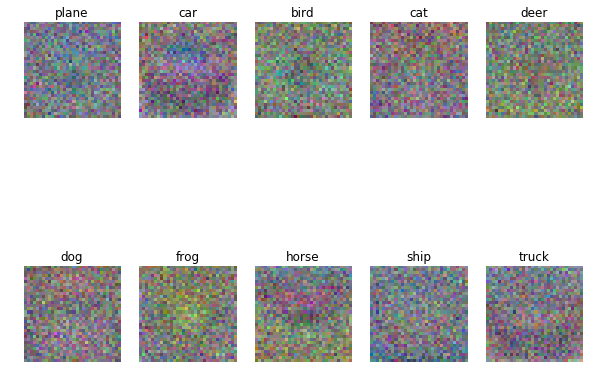

In [91]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])